In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from modules.data_transformation import *

In [7]:
df = pd.read_csv(r"data/Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [8]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [12]:
df['mismatch_count'] = df.apply(
    lambda row: count_mismatches(row['genome_input'], row['sgRNA_input']),
    axis=1
)

df['gc_genome'] = df['genome_input'].apply(calc_gc_content)
df['gc_sgrna'] = df['sgRNA_input'].apply(calc_gc_content)

df['pam'] = df['sgRNA_input'].apply(pam_mmrna)

df['gc_genome'] = df['genome_input'].apply(calc_gc_content)
df['gc_sgrna'] = df['sgRNA_input'].apply(calc_gc_content)

In [ ]:
# df = table_to_dataframe(db_name="crispr_sgRNA.db", table_name="clean_data")

## EDA

Посмотрим на типы данных и количество пропусков в столбцах: 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           26248 non-null  object 
 1   perfect_match_sgRNA  26248 non-null  object 
 2   gene                 26248 non-null  object 
 3   sgRNA_sequence       26248 non-null  object 
 4   mismatch_position    26248 non-null  float64
 5   new_pairing          26248 non-null  object 
 6   K562                 26248 non-null  bool   
 7   Jurkat               26248 non-null  bool   
 8   mean_relative_gamma  26248 non-null  float64
 9   genome_input         26248 non-null  object 
 10  sgRNA_input          26248 non-null  object 
 11  mismatch_count       26248 non-null  int64  
 12  gc_genome            26248 non-null  float64
 13  gc_sgrna             26248 non-null  float64
 14  pam                  26248 non-null  object 
dtypes: bool(2), float64(4), int64(1), ob

Для числовых столбцов посмотрим на основные статистики:

In [5]:
df.describe()

,mismatch position,mean relative gamma,mismatch_count,gc_genome,gc_sgrna
count,26248.000000,26248.000000,26248.00000,26248.000000,26248.000000
mean,-9.053490,0.280410,1.57593,0.683799,0.687885
std,4.946003,0.389325,0.49421,0.086509,0.084510
min,-19.000000,-0.319067,1.00000,0.423077,0.384615
25%,-12.000000,-0.003163,1.00000,0.615385,0.615385
50%,-9.000000,0.058403,2.00000,0.692308,0.692308
75%,-5.000000,0.564199,2.00000,0.730769,0.730769
max,-1.000000,2.278508,2.00000,0.923077,0.961538


Посчитаем корреляцию между числовыми переменными:

In [5]:
df.corr(method='pearson', numeric_only=True)

,mismatch_position,K562,Jurkat,mean_relative_gamma,gc_content
mismatch_position,1.000000,0.005308,0.007886,-0.583286,0.025128
K562,0.005308,1.000000,-0.380945,0.003082,-0.081635
Jurkat,0.007886,-0.380945,1.000000,-0.008141,0.000281
mean_relative_gamma,-0.583286,0.003082,-0.008141,1.000000,0.073448
gc_content,0.025128,-0.081635,0.000281,0.073448,1.000000


In [6]:
df.corr(method='spearman', numeric_only=True)

,mismatch_position,K562,Jurkat,mean_relative_gamma,gc_content
mismatch_position,1.000000,0.004255,0.008163,-0.537291,0.024265
K562,0.004255,1.000000,-0.380945,0.016620,-0.078312
Jurkat,0.008163,-0.380945,1.000000,-0.009089,0.001432
mean_relative_gamma,-0.537291,0.016620,-0.009089,1.000000,0.064414
gc_content,0.024265,-0.078312,0.001432,0.064414,1.000000


Явную корреляцию таргетная переменная имеет только с признаком *mismatch_position*

Распределение некоторых признаков:

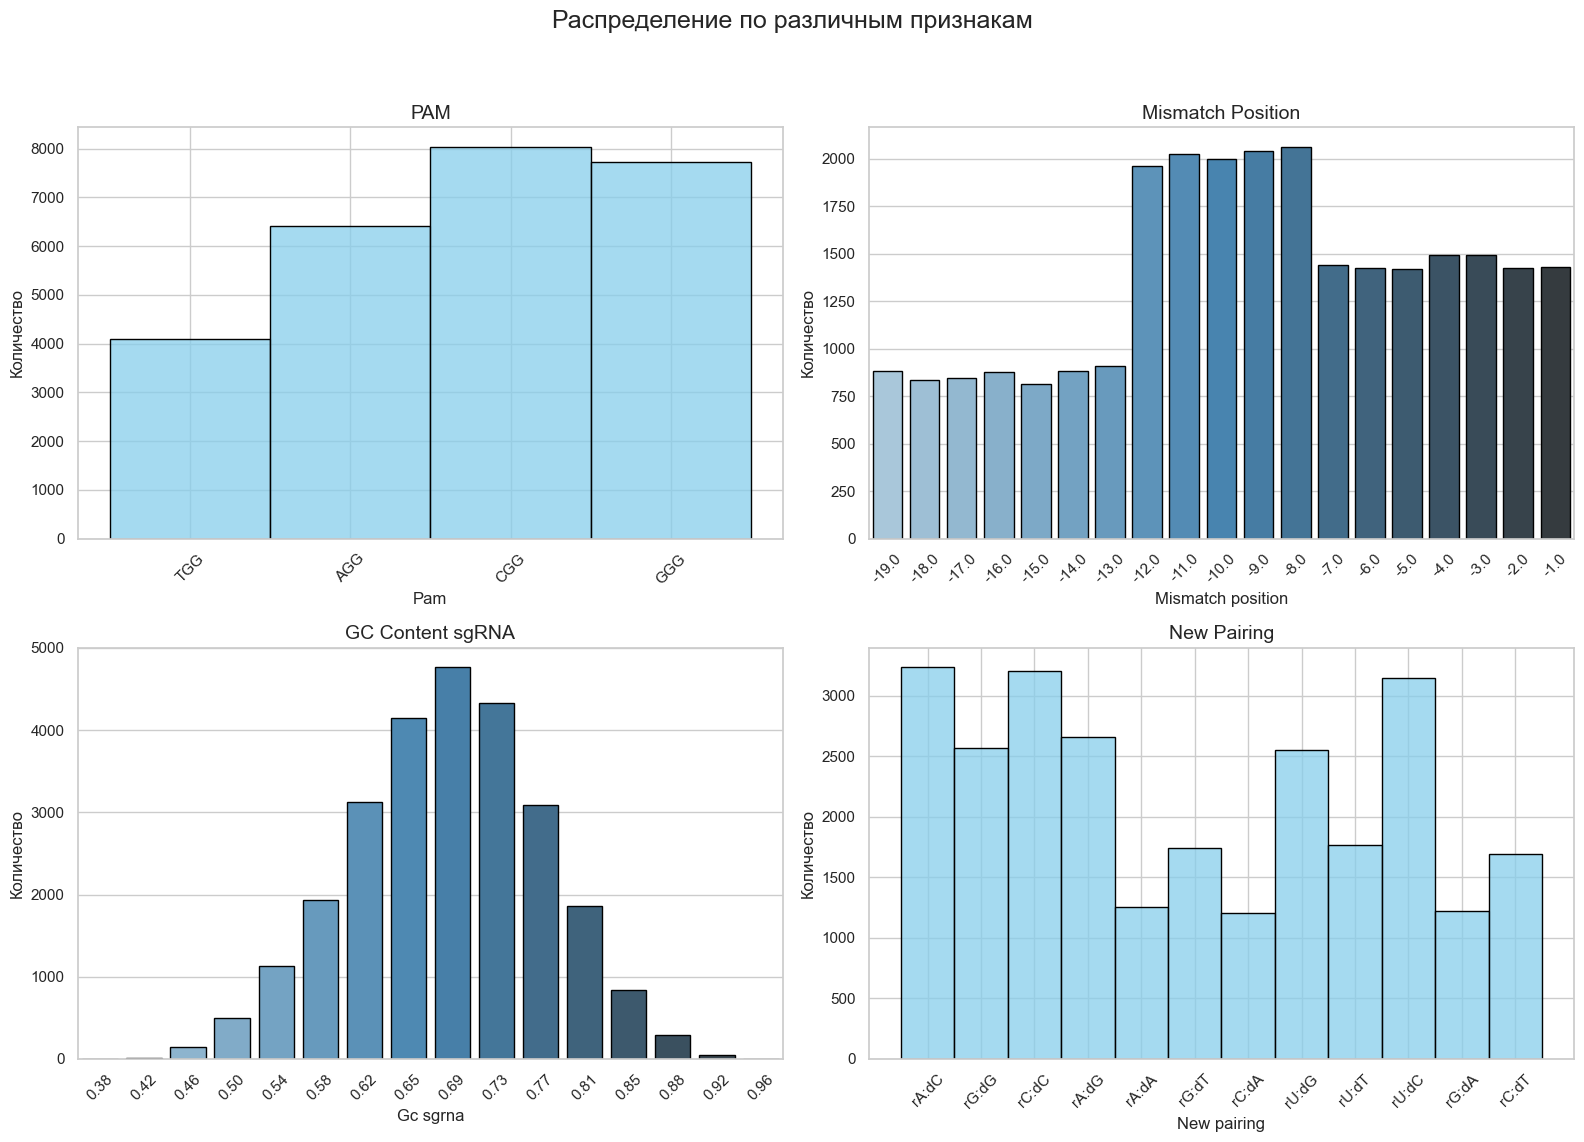

In [13]:
sns.set(style="whitegrid")

df['mismatch_position'] = df['mismatch_position'].astype('category')

def format_gc_content(x):
    if isinstance(x, (float, int)):
        return f"{x:.2f}"
    return x

df['gc_sgrna'] = df['gc_sgrna'].apply(format_gc_content).astype('category')

columns = ["pam", "mismatch_position", "gc_sgrna", "new_pairing"]
titles = ["PAM", "Mismatch Position", "GC Content sgRNA", "New Pairing"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (col, title) in enumerate(zip(columns, titles)):
    if col in ['mismatch_position', 'gc_sgrna']:
        sns.countplot(
            data=df,
            x=col,
            hue=col,
            palette='Blues_d',
            edgecolor='black',
            ax=axes[i]
        )
        
        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()
    else:
        sns.histplot(
            data=df,
            x=col,
            kde=False,
            color='skyblue',
            edgecolor='black',
            ax=axes[i]
        )
    
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=12)
    axes[i].set_ylabel('Количество', fontsize=12)
    
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Распределение по различным признакам", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Построим распределение таргетной величины:

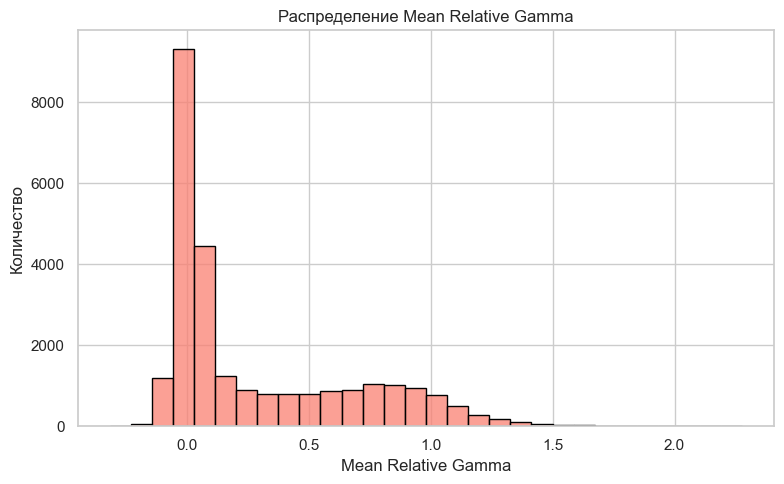

In [14]:
plt.figure(figsize=(8, 5))

sns.histplot(data=df, x="mean_relative_gamma", bins=30, color='salmon', edgecolor='black')

plt.title("Распределение Mean Relative Gamma")
plt.xlabel("Mean Relative Gamma")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

Распределение таргетной величины по группам PAM:

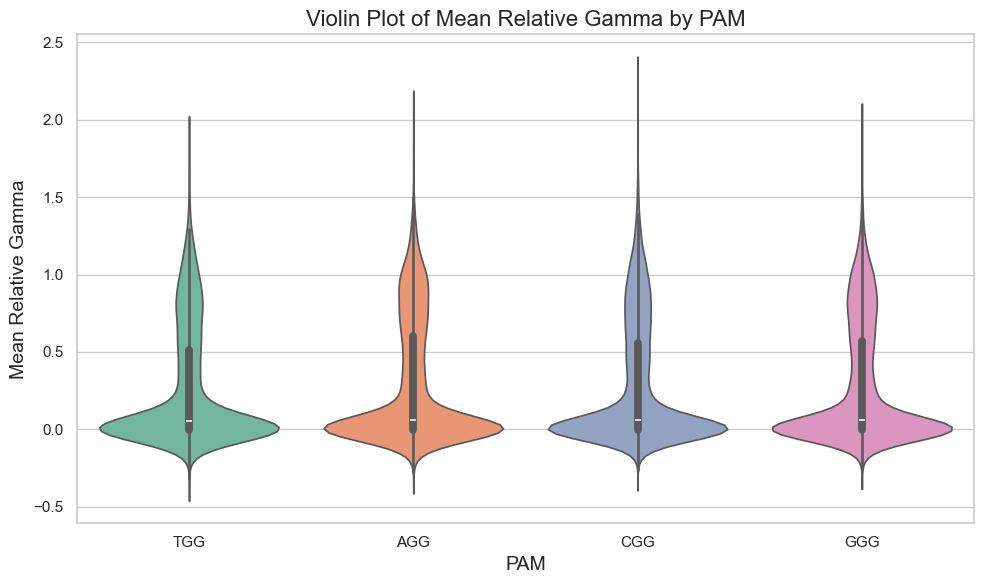

In [15]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='pam',
    y='mean_relative_gamma',
    inner='box',
    hue='pam',
    palette='Set2',
    dodge=False
)

plt.title("Violin Plot of Mean Relative Gamma by PAM", fontsize=16)
plt.xlabel("PAM", fontsize=14)
plt.ylabel("Mean Relative Gamma", fontsize=14)
plt.xticks()

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

Распределение таргетной величины в зависимости от mismatch_position:

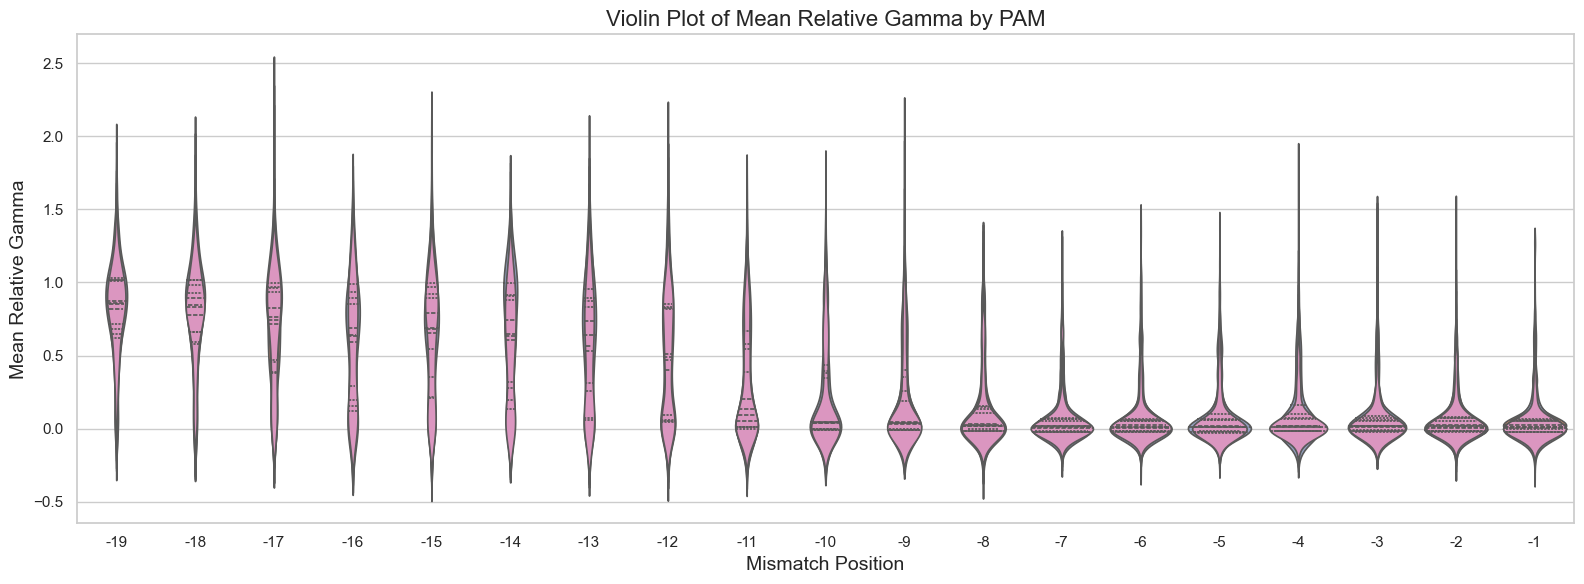

In [15]:
plt.figure(figsize=(16, 6))

sns.violinplot(
    data=df,
    x='mismatch_position',
    y='mean_relative_gamma',
    inner='quarth',
    hue='pam',
    palette='Set2',
    dodge=False
)

plt.title("Violin Plot of Mean Relative Gamma by PAM", fontsize=16)
plt.xlabel("Mismatch Position", fontsize=14)
plt.ylabel("Mean Relative Gamma", fontsize=14)
plt.xticks()

plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()